In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import pysindy as ps 
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso, Ridge, ElasticNet, Lars
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import ElasticNet
from scipy.stats import norm
from datetime import datetime
from scipy.integrate import solve_ivp
from scipy.io import loadmat
from sklearn.metrics import mean_squared_error
from pysindy.utils.odes import lorenz


#### SPY options

In [15]:
calls=pd.read_csv('data/calls.csv')
puts=pd.read_csv('data/puts.csv')
underlying=pd.read_csv('data/underlying_data.csv')

calls.index=calls[calls.columns[0]]
calls=calls.drop(columns=calls.columns[0])

puts.index=puts[puts.columns[0]]
puts=puts.drop(columns=puts.columns[0])

underlying.index=underlying[underlying.columns[0]]
underlying=underlying.drop(columns=underlying.columns[0])

In [16]:
calls['underlying']=underlying['price']
calls.index=[datetime.strptime(i,"%Y-%m-%d") for i in calls.index]
calls['time_to_exp']=[(datetime(2022,9,30)-i).days/365 for i in calls.index]
# calls=calls[calls['time_to_exp']<0.8]
calls=calls.sort_index()[::-1]


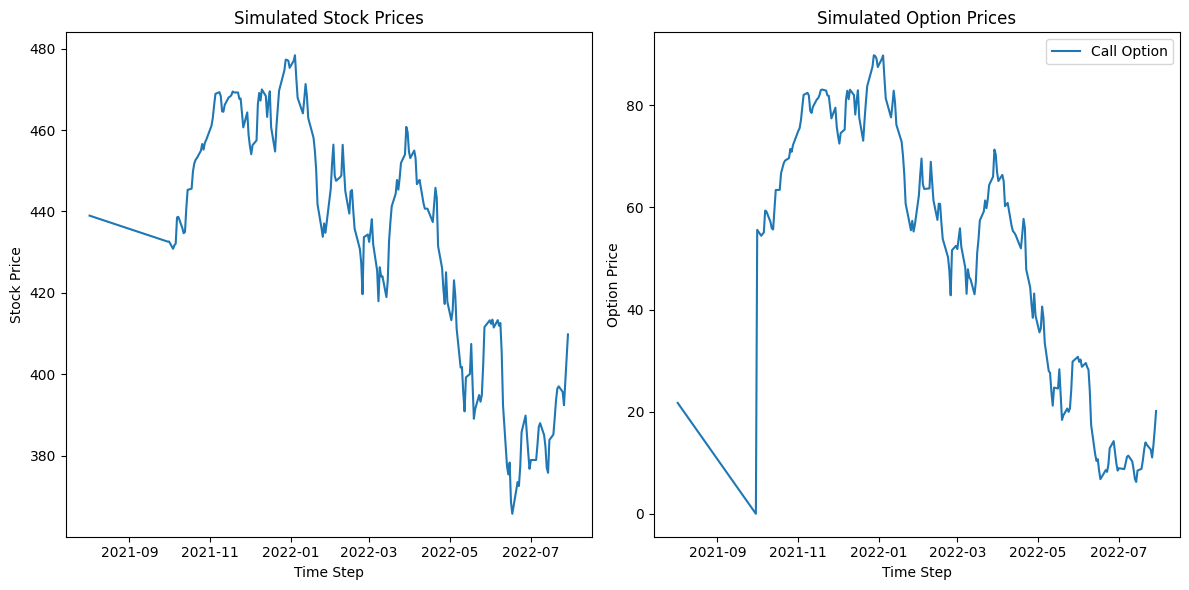

In [17]:
# Plot the simulated stock prices and option prices
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(calls['underlying'])
plt.title('Simulated Stock Prices')
plt.xlabel('Time Step')
plt.ylabel('Stock Price')

plt.subplot(1, 2, 2)
plt.plot(calls['price'], label='Call Option')
# plt.plot(option_prices_put, label='Put Option')
plt.title('Simulated Option Prices')
plt.xlabel('Time Step')
plt.ylabel('Option Price')
plt.legend()

plt.tight_layout()
plt.show()

In [85]:
u = np.real(calls['price'])
t = np.ravel(calls['time_to_exp'])
x = np.ravel(calls['underlying'])
# u_dot =  ps.FiniteDifference(axis=0)._differentiate(x= C,t=dt)
# dt = 1
# dt = ps.FiniteDifference(axis=0)._differentiate(x= t,t=1)

### Synthetic Option

In [4]:
import numpy as np
from scipy.stats import norm

def black_scholes_call(S, X, T, r, sigma):
    d1 = (np.log(S / X) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    call_price = S * norm.cdf(d1) - X * np.exp(-r * T) * norm.cdf(d2)
    return call_price

# Constants
S0 = 100
r = 0.05
sigma = 0.5
K = 105

# Monte Carlo simulation
x = np.arange(S0 / 2, K*3, .01)
t = np.arange(0, 256, .1)
X, T = np.meshgrid(x, t)

dt = t[1] - t[0]
dx = x[1] - x[0]

X, T = np.meshgrid(x, t)
XT = np.asarray([X, T]).T

# Calculate 'tal' using vectorized operations
tal = (len(t) - T) / len(t)

# Calculate the call prices using vectorized operations
call_prices = black_scholes_call(X, K, tal, r, sigma)

# u is the call_prices array
u = call_prices.T

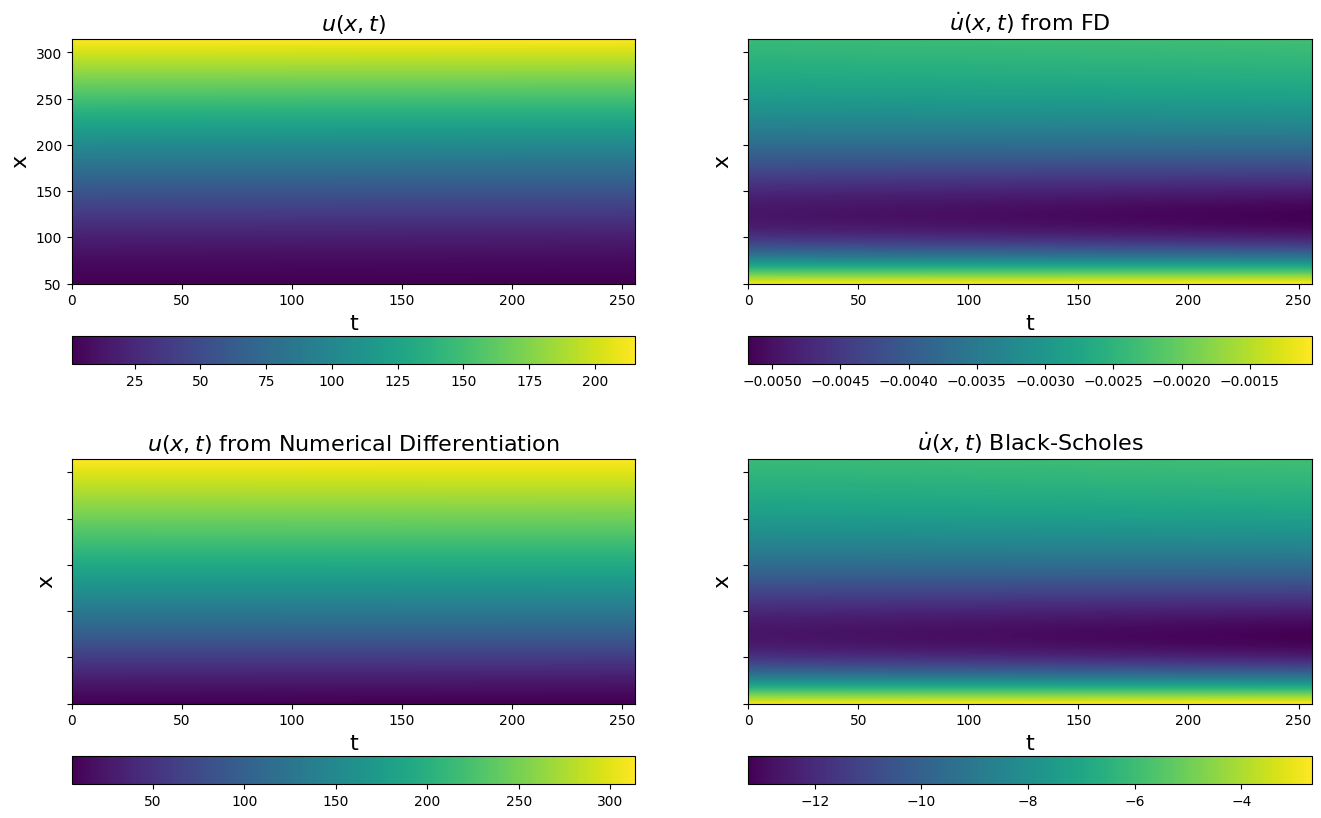

In [159]:
# rmse = mean_squared_error(u, np.zeros(u.shape), squared=False)
# add 20% noise (note the impact on derivatives depends on step size...)
# u = u + np.random.normal(0, rmse / 5.0, u.shape)
u_x = ps.FiniteDifference(axis=0,order = 2)._differentiate(u,t = dx)
u_xx = ps.FiniteDifference(axis=0,d=2,order = 2)._differentiate(u,t = dx)

# Plot u and u_dot
plt.figure(figsize=(16, 10))
plt.subplot(2, 2, 1)
plt.pcolormesh(t, x, u)
plt.xlabel("t", fontsize=16)
plt.ylabel("x", fontsize=16)
plt.title(r"$u(x, t)$", fontsize=16)
plt.colorbar(orientation="horizontal")

u_dot_ = ps.FiniteDifference(axis=1,order = 2)._differentiate(u,t = dt)
plt.subplot(2, 2, 2)
plt.pcolormesh(t, x, u_dot_)
plt.xlabel("t", fontsize=16)
plt.ylabel("x", fontsize=16)
ax = plt.gca()
ax.set_yticklabels([])
plt.title(r"$\dot{u}(x, t)$ from FD", fontsize=16)
plt.colorbar(orientation="horizontal")


u_dot = -1/2*(sigma**2)*u_xx*(X.T**2) - r*X.T*u_x + r*u
plt.subplot(2, 2, 4)
plt.pcolormesh(t, x, u_dot)
plt.xlabel("t", fontsize=16)
plt.ylabel("x", fontsize=16)
ax = plt.gca()
ax.set_yticklabels([])
plt.title(r"$\dot{u}(x, t)$ Black-Scholes", fontsize=16)
plt.colorbar(orientation="horizontal")

u_ = (1/2*r)*((sigma**2)*(X.T**2)*(u_xx)) + ((X.T)*(u_x)) - u_dot_
plt.subplot(2, 2, 3)
plt.pcolormesh(t, x, u_)
plt.xlabel("t", fontsize=16)
plt.ylabel("x", fontsize=16)
ax = plt.gca()
ax.set_yticklabels([])
plt.title(r"$u(x, t)$ from Numerical Differentiation", fontsize=16)
plt.colorbar(orientation="horizontal")


plt.show()
# See how much SmoothedFiniteDifference improves the derivatives!

In [172]:
u[:,:,0]

array([[  1.31310329,   1.31299089,   1.3128785 , ...,   1.03511914,
          1.03501439,   1.03490965],
       [  1.32598764,   1.32587448,   1.32576134, ...,   1.04605641,
          1.04595089,   1.04584538],
       [  1.3389561 ,   1.33884219,   1.33872829, ...,   1.05707267,
          1.05696639,   1.0568601 ],
       ...,
       [215.14169836, 215.14145921, 215.14122008, ..., 214.53909355,
        214.53886143, 214.53862931],
       [215.24115296, 215.24091388, 215.24067479, ..., 214.63868668,
        214.63845461, 214.63822254],
       [215.34060856, 215.34036953, 215.34013051, ..., 214.73828061,
        214.73804859, 214.73781658]])

### PySINDy

In [178]:
u = np.reshape(u, (len(x), len(t), 1))
u_ = np.reshape(u_, (len(x), len(t), 1))
u_dot  = np.reshape(u_dot, (len(x), len(t), 1))
u_dot_ = np.reshape(u_dot_, (len(x), len(t), 1))
spatial_grid = np.reshape(X.T, (len(x), len(t), 1))
library_functions = [lambda x: x]
library_function_names = [lambda x: x]

pde_lib = ps.PDELibrary(
    library_functions=library_functions,
    function_names=library_function_names,
    include_interaction = False,
    derivative_order=2,
    spatial_grid=x,
    include_bias=False,
    is_uniform=True,
)

u_final = pde_lib.fit_transform(u_)
u_final = np.concatenate((u_final,spatial_grid,spatial_grid**2),axis=2)
dic_var = {'x0':'u','x1':'u_x', 'x2':'u_xx','x3':'x','x4':'x^2'}
library_functions = [lambda x: x,lambda x,y: x*y]
library_function_names = [lambda x: dic_var[x],lambda x,y: dic_var[x] + '*' + dic_var[y]]
lib = ps.CustomLibrary(
    library_functions=library_functions,
    function_names=library_function_names,
    include_bias=True
)

In [179]:

# Fit and predict with the non-weak model
print('SR3 Regression')

opt = ps.SR3(
    threshold=8, thresholder="l1", tol=1e-12, normalize_columns=True, max_iter=1000000
)
model_for_prediction = ps.SINDy(feature_library=lib, optimizer=opt)
model_for_prediction.fit(u_final,x_dot = u_dot)
# print(model_for_prediction.score(u_test))
# Prints a very wrong model
model_for_prediction.print()

SR3 Regression


KeyboardInterrupt: 

In [180]:
print('STLSQ Regression')
optimizer = ps.STLSQ(threshold=10, alpha=1e-12, normalize_columns=True)
model = ps.SINDy(feature_library=lib, optimizer=optimizer)
model.fit(u_final,x_dot = u_dot)
# print(model.score(u_test))
model.print()

STLSQ Regression
(x0)' = -0.192 1 + 0.056 u + 0.132 u_x + 3.282 u_xx + 0.012 x + 0.008 u*u_x + 0.089 u*u_xx + 0.001 u*x + 1.601 u_x*u_xx + -0.116 u_x*x + -0.111 u_xx*x


In [177]:
print('STLSQ Regression')
optimizer = ps.STLSQ(threshold=0, alpha=0, normalize_columns=True)
model = ps.SINDy(feature_library=lib, optimizer=optimizer)
model.fit(u_final,x_dot = u_dot_)
# print(model.score(u_test))
model.print()

STLSQ Regression
(x0)' = 0.000


In [185]:
spatial_grid = np.reshape(x, (len(x),1))

# Define weak form PDE library
library_functions = [lambda x: x]
library_function_names = [lambda x: x]

pde_lib = ps.WeakPDELibrary(
    library_functions=library_functions,
    function_names=library_function_names,
    derivative_order=2,
    spatiotemporal_grid=XT,
    is_uniform=False,
    include_interaction = False,
    K=10000,
)

u_final = pde_lib.fit_transform(u)
u_final = np.concatenate((u_final,spatial_grid,spatial_grid**2),axis=1)
dic_var = {'x0':'u','x1':'u_x', 'x2':'u_xx','x3':'x','x4':'x^2'}
library_functions = [lambda x: x,lambda x,y: x*y]
library_function_names = [lambda x: dic_var[x],lambda x,y: dic_var[x] + '*' + dic_var[y]]
lib = ps.CustomLibrary(
    library_functions=library_functions,
    function_names=library_function_names,
    include_bias=True
)

print('SR3 Regression')
# Fit a weak form model
optimizer = ps.SR3(
    threshold=.1, thresholder="l1", tol=1e-8, normalize_columns=True, max_iter=1000
)
model = ps.SINDy(feature_library=lib, optimizer=optimizer)
model.fit(u,x_dot =u_dot , quiet=True)
print(model.score(u))
model.print()

print('STLSQ Regression')
optimizer = ps.STLSQ(threshold=5, alpha=1e-5, normalize_columns=True)
model = ps.SINDy(feature_library=lib, optimizer=optimizer)
model.fit(u,x_dot = u_dot , quiet=True)
print(model.score(u))
model.print()

SR3 Regression
-109466.03964275101
(x0)' = -4.240 1 + -0.101 u
STLSQ Regression
-109466.03964275101
(x0)' = -4.240 1 + -0.101 u
